## **Notebook 3: Introduction to Numba**

This tutorial introduces Numba basics and common usages before diving into our main nearest neighbors example. Numba is a just-in-time compiler optimized for numerically-focused Python functions that can work on the CPU or the GPU. Numba can compile a large number of NumPy functions and can create ufuncs (universal functions), parallelize loops, and generate GPU-accelerated code.

In [1]:
from numba import (cuda,  
                   float32,
                   jit, 
                   vectorize,
                   guvectorize)

import numpy as np
import cupy as cp
import time
import matplotlib.pyplot as plt

ImportError: libjpeg.so.62: cannot open shared object file: No such file or directory

---

**Numba Vectorize/Guvectorize**

The Numba `vectorize` decorator compiles a Python function that takes a scalar input into a [NumPy ufuncs](https://numpy.org/doc/stable/reference/ufuncs.html). These ufuncs or universal functions work elementwise over NumPy ndarrays. This is an example of a dynamic unfunc (DUFunc), as we are not passing in any signatures to our vectorize decorator. When a different input type is passed, we will dynamically compile a new kernel.

We are running the relative difference ufunc below on the CPU.

In [3]:
@vectorize()
def rel_diff_cpu(x, y):
    return 2 * (x - y) / (x + y)


In [4]:
import numba
import numpy

@numba.vectorize(nopython=True, cache=True)
def v_floor(a):
    return numpy.floor(a)

print(numba.__version__)
print(numpy.__version__)

v_floor(1.9)

0.56.2
1.21.6


1.0

In the next cell we run our relative difference function on increasing NumPy array sizes. We are timing a NumPy ufunc implementation and our Numba ufunc implementation. Note we are ignoring divide by zero errors we might get with this method of random number generation. 

In [ ]:
size_list = [10, 10000, 100000, 1000000, 10000000, 100000000]
numpy_cpu_times = []
numba_cpu_times = []

np.seterr(divide='ignore')

for size in size_list:
    x=np.random.randn(size)#.astype(np.float32)
    y=np.random.randn(size)#.astype(np.float32)

    start_time_numpy = time.monotonic()
    2 * (x - y) / (x + y)
    numpy_cpu_times += [(time.monotonic() - start_time_numpy)]

    start_time_numba_cpu = time.monotonic()
    rel_diff_cpu(x, y)
    numba_cpu_times += [(time.monotonic() - start_time_numba_cpu)]

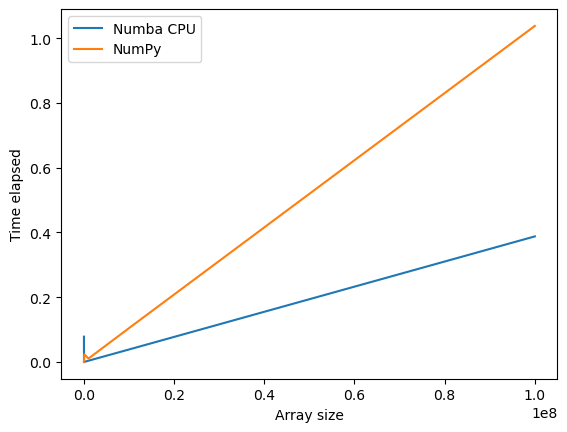

In [5]:
plt.plot(size_list, numba_cpu_times, label="Numba CPU")
plt.plot(size_list, numpy_cpu_times, label="NumPy")
plt.legend()
plt.xlabel("Array size")
plt.ylabel("Time elapsed")
plt.show()

Next let's walk through a `guvectorize` example, calculating a moving average. In this case we are illustrating Eager/decoration-time compilation where we pass the type signatures. In general, with `guvectorize` we can work on an arbitrary number of elements of input arrays (as opposed to one element at a time with `vectorize`).

The layout in symbolic form `(n),()->(n)`is how we tell NumPy that we take in an input array of shape `n` and a constant which is represented by the `()`. Then the output of this function will also be of the same shape as our original input array `(n)`.

Also note in guvectorize we don't have a return, but write our results to one of the arguments, in this case `out`. This is particularly useful because with guvectorize we can have return arrays of differing dimensions.


In [6]:
@guvectorize(['void(float64[:], intp[:], float64[:])'], '(n),()->(n)')
def move_mean(a, window_arr, out):
    window_width = window_arr[0]
    asum = 0.0
    count = 0
    for i in range(window_width):
        asum += a[i]
        count += 1
        out[i] = asum / count
    for i in range(window_width, len(a)):
        asum += a[i] - a[i - window_width]
        out[i] = asum / count

In [7]:
arr = np.arange(30, dtype=np.float64).reshape(3,10)
print("Input array:")
print(arr)
print("Output array:")
print(move_mean(arr, 3))

Input array:
[[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9.]
 [10. 11. 12. 13. 14. 15. 16. 17. 18. 19.]
 [20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]]
Output array:
[[ 0.   0.5  1.   2.   3.   4.   5.   6.   7.   8. ]
 [10.  10.5 11.  12.  13.  14.  15.  16.  17.  18. ]
 [20.  20.5 21.  22.  23.  24.  25.  26.  27.  28. ]]


---

**Custom Numba Kernels: Interoperability**

In general, we recommend using CuPy arrays when writing Numba code targeting the GPU. Below in our L2 norm calculation we will use CuPy arrays with our Numba kernels.

Our first `sum_reduce` function uses the `reduce` decorator which takes our binary summation operation and turns it into a reduction kernel, running one the GPU as indicated by the `cuda` in our decorator. 

In [8]:
@cuda.reduce
def sum_reduce(a, b):
    return a + b

The next kernel is our first just-in-time kernel targeting the GPU. We use:

`cuda.grid` The absolute position of the current thread in the entire grid of blocks \
`cuda.gridsize` The size in threads of the entire grid of blocks

We can safely loop over the data using one thread per data element, without assuming we have enough threads to cover the whole array size. Instead we loop over our data one grid size at a time (aka one stride).

In [9]:
@cuda.jit
def numba_l2_norm(x):
    start = cuda.grid(1)
    stride = cuda.gridsize(1)

    for i in range(start, x.shape[0], stride):
        x[i] = x[i] * x[i]

Go ahead and change our problem size `x` to see how varying the array size affects both NumPy and Numba performance. Also explore how we can adjust our  <code>threads_per_block</code> to get the best utilization of the GPU.

Note, if we weren't comparing the NumPy implementation, we could create our d_x directly using <code>d_x = cp.random.rand(2**26)</code>.

In [10]:
x = np.random.rand(2**22)
d_x =cp.array(x)
threads_per_block = 1024
blocks_per_grid = (d_x.size + (threads_per_block - 1)) // threads_per_block

In [11]:
start_time = time.monotonic()
numba_l2_norm[blocks_per_grid, threads_per_block](d_x)
output = cp.sqrt(sum_reduce(d_x))
print("Numba time elapsed (fractional seconds): ", time.monotonic() - start_time)
print("Numba output: ", output)

start_time_np = time.monotonic()
np.linalg.norm(x, 1)
print("NumPy time elapsed (fractional seconds):" , time.monotonic() - start_time_np)
print("NumPy output: ", output)

/opt/conda/envs/rapids/lib/python3.9/site-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 64 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/opt/conda/envs/rapids/lib/python3.9/site-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Numba time elapsed (fractional seconds):  4.711460737511516
Numba output:  1181.995920294273
NumPy time elapsed (fractional seconds): 0.016373537480831146
NumPy output:  1181.995920294273


You will see the first couple of calls to the Numba kernel are slower than the NumPy implementation, but after a couple reruns, the performance levels out and Numba is much faster.

This example also shows us how the GPU and specifically custom Numba kernels as we have written will perform well with very large input data (it also does better when the problem is more complicated than we have demonstrated above). To show this point, when you decrease the input size, the NumPy implementation will greatly outperform our solution. 

---

**Numba custom kernels: SAXPY**

Below we have a simple SAXPY kernel that utilizes the `vectorize` decorator. We specify the expected types therefore doing eager compilation, and make sure to set the target to run on the GPU. You can see when we are calling a function with the decorator it is different from how we call our <code>@cuda.jit</code> functions. We do not have to pass our <code>[blocks_per_grid, threads_per_block]</code>. 

In [12]:
@vectorize(['float32(float32, float32, float32)'], target='cuda')
def saxpy(a, x, y):
    return a * x + y

In [13]:
N = 2**25
A=cp.random.randn(N).astype(cp.float32)
B=cp.random.randn(N).astype(cp.float32)

%time C = saxpy(2.0, A, B)

CPU times: user 172 ms, sys: 68.1 ms, total: 240 ms
Wall time: 260 ms


Experiment with differnt array sizes by changing `N` and seeing how the performance of our Numba timing changes.

---

**Numba custom kernels: fast matrix multiplication**

In this final section of our Numba introduction we will use a common example of GPU performance - matrix multiplication.

In [18]:
threads_per_block = 16
blocks_per_grid = 128

If you are new to CUDA concepts or thread hierarchy, keep the threads per block and BPG blocks per grid the same, but if you are curious, test out how changing that value affects your performance.

In [19]:
@cuda.jit
def fast_matmul(A, B, C):
    sA = cuda.shared.array(shape=(threads_per_block, threads_per_block), dtype=float32)
    sB = cuda.shared.array(shape=(threads_per_block, threads_per_block), dtype=float32)

    x, y = cuda.grid(2)

    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    blocks_per_grid = cuda.gridDim.x

    tmp = float32(0.)
    for i in range(blocks_per_grid):
        sA[ty, tx] = 0
        sB[ty, tx] = 0
        if y < A.shape[0] and (tx + i * threads_per_block) < A.shape[1]:
            sA[ty, tx] = A[y, tx + i * threads_per_block]
        if x < B.shape[1] and (ty + i * threads_per_block) < B.shape[0]:
            sB[ty, tx] = B[ty + i * threads_per_block, x]
        cuda.syncthreads()

        for j in range(threads_per_block):
            tmp += sA[ty, j] * sB[j, tx]
            
        cuda.syncthreads()
    if y < C.shape[0] and x < C.shape[1]:
        C[y, x] = tmp

Now we will show how to call and time this fast matrix multiplication kernel we have written.

In [20]:
x_d = cp.arange(1000).reshape([50,20])
y_d = cp.ones([50,20])
z_d = cp.zeros([50,20])

%time fast_matmul[blocks_per_grid, threads_per_block](x_d, y_d, z_d)

CPU times: user 432 ms, sys: 19.7 ms, total: 452 ms
Wall time: 475 ms


Below we call our Numba kernel on NumPy arrays, see on the first pass we should get a warning about the conversion to a device array happening. The warning will go go away once you have run the cells again. Go ahead and run the cell above and below again, notice the changes in performance.

In [21]:
x_d = np.arange(1000).reshape([50,20])
y_d = np.ones([50,20])
z_d = np.zeros([50,20])

%time fast_matmul[blocks_per_grid, threads_per_block](x_d, y_d, z_d)

CPU times: user 2.35 ms, sys: 0 ns, total: 2.35 ms
Wall time: 2.35 ms


/opt/conda/envs/rapids/lib/python3.9/site-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


---

**Please restart the kernel**

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)